#  Word Embedding Demo

In this demo, we will guide you through the basic steps for creating word representations using skip-gram neural network architecture.

In your homework, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

The sample code for skip-gram model is given. Your job is to incorporate the tokenizer model that you created in HomeWork-1 to tokenize raw text and turn it into word vectors.

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 best categories)  (compare)


This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.

As a reminder,

### Don't forget to shut down your instance on Gcloud when you are not using it ###

In [1]:
%matplotlib inline
import numpy as np
import math

import glob
import re
import random
import collections
import os
import sys

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K


Using TensorFlow backend.


## Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
#Step 1: read the wikipedia text file

cwd = os.getcwd()

#with open(cwd+"/corpora/wiki/thwiki_chk.txt") as f:
with open("/home/ekapolc/corpora/wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [3]:
print("total word count:", len(input_text))

total word count: 36349066


## Step 2: Indexing (Assign a number to each word)

The given code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary




Your job is to set a threshold for rare words and replace them with "UNK"

+ Please tell how you choose a number for your threshold

In [4]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text):
    
    words = [word for word in input_text ]
    word_count = list()
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    word_count.append(("UNK",0))
    #print out 10 most frequent words
    print(word_count[:10])
    dictionary = dict()
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        data.append(dictionary[word])

    return data,dictionary, reverse_dictionary

dataset,dictionary, reverse_dictionary=create_index(input_text)
del input_text #just to clear up some memory

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]


In [5]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [228, 207, 2452, 572, 14, 1828, 7172, 3124, 680, 23]
output sample (dictionary): {'ใจกลางเปียงยาง': 618855, 'Nuevo': 295169, 'เกียรติบันลือ': 295167, 'ฮัมเดน': 127222, 'บ็อบ': 10183, 'เอี่ยมเนตร': 295163, 'เรียนทุ่งช้าง': 295164, 'โมบลี': 295165, 'จากรุก': 295168, 'Bickenhill': 295166}
output sample (reverse dictionary): {0: 'ที่', 1: 'ใน', 2: 'เป็น', 3: 'และ', 4: 'การ', 5: 'มี', 6: 'ของ', 7: 'ได้', 8: ')', 9: '"'}


In [6]:
len(dictionary) #number of unique words

701355

# Step3: Create skip-grams (inputs for your model)


In [7]:
# Step 3: Create data samples 
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]],labels[i])



[[7172, 3124], [7172, 1828], [7172, 278989], [7172, 475628]] [1, 1, 0, 0]
วิกิ มีเดีย 1
วิกิ มูลนิธิ 1
วิกิ โกโกส 0
วิกิ 戒幢律寺 0


IndexError: list index out of range

# Step 4: create the skip-gram model
![Skip-gram model](https://raw.githubusercontent.com/ekapolc/nlp_course/master/HW3/skipgram.png)


In [10]:
#reference:  https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb


dim_embedddings = 32 #embedding dimension
V= len(dictionary) #Vocab size

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)

#step3: compute the dot product:w*c
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 32)         22443360    input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 32)         22443360    input_2[0][0]                    
___________________________________________________________________________________________

In [ ]:
# Train for 5 epoch
#it will take roughly 3-4 hours for each epoch
# PRO TIPS: you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
for _ in range(5):
    prev_i=0
    #it is likely that your GPU won't be able to handle 36 million words
    #just do it 100000 words at a time
    
    for i in range(len(dataset)//100000):
        #generate skipgrams
        data, labels = skipgrams(sequence=dataset[prev_i:i+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        
        print(loss,i*100000)



In [12]:
#SkipGram.save_weights('/data/my_skipgram32_weights.h5')

In [11]:
SkipGram.load_weights('/data/my_skipgram32_weights.h5')

ResourceExhaustedError: OOM when allocating tensor with shape[]
	 [[Node: Adam/lr/Assign = Assign[T=DT_FLOAT, _class=["loc:@Adam/lr"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Adam/lr, Adam/lr/initial_value)]]

Caused by op 'Adam/lr/Assign', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ekapolc/.env/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/ekapolc/.env/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ekapolc/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3012, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ekapolc/.env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-addf063b42bc>", line 24, in <module>
    SkipGram.compile(loss='binary_crossentropy', optimizer='adam')
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/engine/training.py", line 624, in compile
    self.optimizer = optimizers.get(optimizer)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/optimizers.py", line 717, in get
    return deserialize(config)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/optimizers.py", line 689, in deserialize
    printable_module_name='optimizer')
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/utils/generic_utils.py", line 141, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/optimizers.py", line 127, in from_config
    return cls(**config)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/optimizers.py", line 406, in __init__
    self.lr = K.variable(lr, name='lr')
  File "/home/ekapolc/.env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 316, in variable
    v = tf.Variable(value, dtype=_convert_string_dtype(dtype), name=name)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 320, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py", line 274, in assign
    validate_shape=validate_shape)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 43, in assign
    use_locking=use_locking, name=name)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ekapolc/.env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[]
	 [[Node: Adam/lr/Assign = Assign[T=DT_FLOAT, _class=["loc:@Adam/lr"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Adam/lr, Adam/lr/initial_value)]]


In [ ]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)

# Step 5: Visualize the embeddings

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is suited for the visualization of high-dimensional datasets. You don't need to understand t-SNE to complete this course, but it is a very powerful tool of visualizing your word vectors. You can read more about t-SNE here: https://lvdmaaten.github.io/tsne/

In [ ]:
# Step 5: Visualize the embeddings.
# Function to draw visualization of distance between embeddings.
#reference: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    fp = mpl.font_manager.FontProperties(family='TH Sarabun New')
    plt.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontproperties=fp)
    plt.show()
    plt.savefig(filename)

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)
 


# Visualization: Tensorboard

http://bit.ly/2s0SNHl 

In [92]:
#VISUALIZATION ON TENSORBOARD
#reference: https://github.com/keras-team/keras/pull/5247
from keras.callbacks import TensorBoard
import tensorflow as tf

#you need two files to represent data on tensorboard projector
#1 weights
#2 metadata 
import csv
with open('/data/weights.tsv', 'w') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    writer.writerows(final_embeddings[:10000])

with open('/data/metadata.tsv', 'w') as tsvfile:
    for i in range(10000):
        tsvfile.write(reverse_dictionary[i]+"\n")
        



# Step 7: Evaluation
"Of course the most important evaluation metric for vector models is extrinsic evaluation
on tasks; adding them as features into any NLP task and seeing whether this
improves performance.

Nonetheless it is useful to have intrinsic evaluations. The most common metric
is to test their performance on similarity, and in particular on computing the
correlation between an algorithm’s word similarity scores and word similarity ratings
assigned by humans" - Dan Jarafsky (reference: https://web.stanford.edu/~jurafsky/slp3/15.pdf)

Cosine similarity is an important metric for measuring similarity between words. In this demo, we will guide you through some examples that you might be able to use to evaluate your models.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
#sci-kit learns provide a simple module that you can use to calculate cosine similarity
print(cosine_similarity(final_embeddings[dictionary["ไง"]].reshape(1, -1), final_embeddings[dictionary["ชวน"]].reshape(1, -1)))

[[-0.03682636]]


In [17]:
final_embeddings[dictionary["ประเทศไทย"]]

array([ 0.58669341,  0.54148865, -0.60007215,  0.64678901,  0.70417434,
        0.62284714, -0.62249666,  0.54382384,  0.7081365 ,  0.62931299,
       -0.69667792,  0.71439731,  0.69069183, -0.59075159, -0.62458253,
        0.54854584, -0.65565348,  0.54297113, -0.56244928, -0.57262307,
       -0.69184369, -0.6548087 ,  0.55907404,  0.57358831,  0.58288246,
        0.6439184 , -0.59740955,  0.6719209 , -0.56868756, -0.64249682,
        0.64433581,  0.66374224], dtype=float32)

In [26]:
import scipy
#scipy also provides you with a module that you can use to compare your target words against all the words in your corpus
v = final_embeddings[dictionary["ดี"]].reshape(1, -1)
#just compare with top 10000 words....
all_dist = scipy.spatial.distance.cdist(final_embeddings[:10000], v, 'cosine').reshape(-1)
# get 20 nearest vector 
# argpartition can get top twenty very quickly, but they are not sorted
idx =np.argpartition(all_dist, 20)[:20]
#sort
idx = idx[np.argsort(all_dist[idx[:20]])]
for i in idx:
    print(reverse_dictionary[i])

ดี
กระสุน
ยืน
จริง
ก้าว
ครั้งนี้
ซึ่งตั้ง
ภาพยนตร์แอนิเมชัน
ดวงจันทร์
ซื่อ
วิกิพีเดีย
แม่น้ำเจ้าพระยา
ถือกำเนิด
ทุ
เศร้า
จังหวัดราชบุรี
1903
สูท
ติง
ลิเบีย


In [ ]:
#to do any visualization you must reduce the dimension of your word vectors to 2D or 3D...
tsne2 = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 10000#only top 10000 words
low_dim_embs2 = tsne2.fit_transform(final_embeddings[:plot_only, :])

In [41]:
print(cosine_similarity(final_embeddings[dictionary["ประเทศไทย"]].reshape(1, -1), final_embeddings[dictionary["ประเทศญี่ปุ่น"]].reshape(1, -1)))
print(cosine_similarity(final_embeddings[dictionary["ประเทศไทย"]].reshape(1, -1), final_embeddings[dictionary["ไส้กรอก"]].reshape(1, -1)))

[[ 0.99145126]]
[[-0.19122621]]


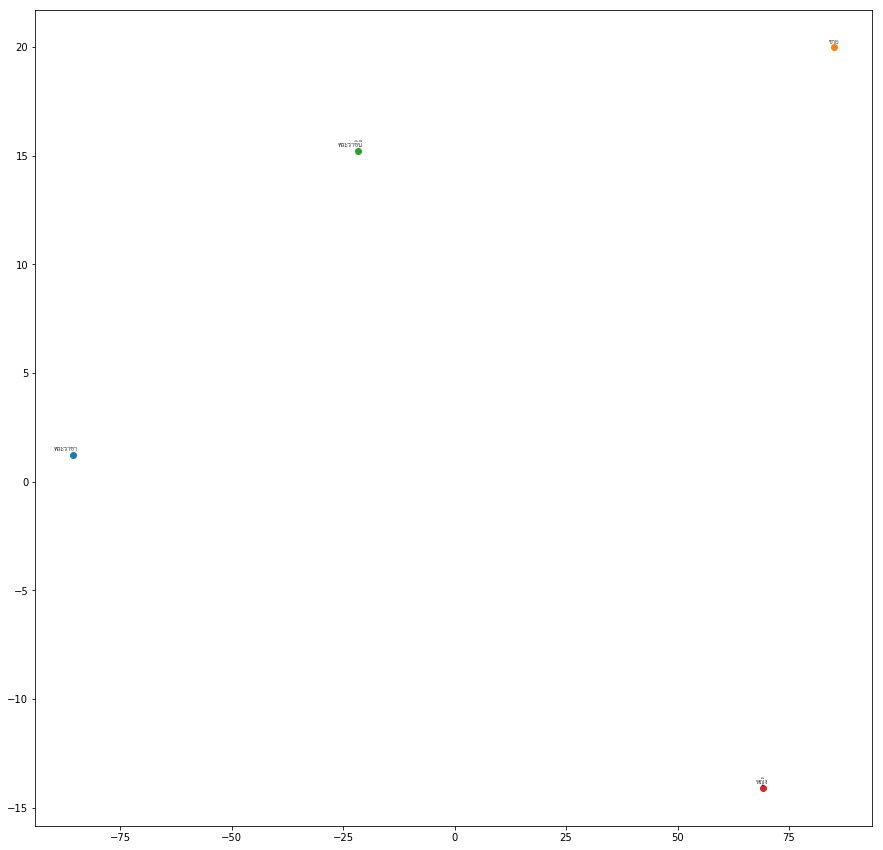

In [110]:
#Visualizing the famous "king-male+female=queen" 
labels = [reverse_dictionary[i] for i in range(plot_only)]
word_list = ['พระราชา','ชาย','พระราชินี','หญิง']
idx_list = []
for word in word_list:
    idx_list.append(labels.index(word))
word_plot = low_dim_embs2[idx_list]
plot_with_labels(word_plot,word_list,filename="queen_king.png")